<a href="https://colab.research.google.com/github/Frans-Grau/P5-Forecasting/blob/main/M_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import plotly.express as px

# from statsmodels.tsa.arima.model import ARIMA

In [2]:
### Load the Datasets
#originalyy downloaded from https://www.kaggle.com/datasets/sherrytp/airline-delay-analy
df2016 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2016.csv')
df2017 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2017.csv')
df2018 = pd.read_csv('https://raw.githubusercontent.com/Frans-Grau/Datasets/main/P5%20-%20Datasets/df2018.csv')

### Quick preprocessing
df_all = pd.concat([df2016,df2017,df2018], ignore_index = True, axis = 0)
df_all.drop(['Unnamed: 0','CANCELLED','DIVERTED'], axis=1, inplace= True)
df_all.dropna(inplace=True)
df_all['FL_DATE'] = pd.to_datetime(df_all['FL_DATE'])
df_all['AIRLINE'] = df_all['OP_CARRIER'].apply(lambda x: 'Delta Airlines' if x == 'DL' else 'Southwest Airlines' if x=='WN' else 'American Airlines' if x=='AA'
else 'JetBlue Airways' if x=='B6' else 'SkyWest Airlines' if x=='OO' else 'Atlantic Southeast Airlines' if x == 'EV' else 'United Airlines' if x == 'UA'
else 'Pinnacle Airlines' if x == '9E' else 'Spirit Airlines' if x== 'NK' else 'Alaska Airlines' if x == 'AS' else 'Virgin America' if x == 'VX' else 'Frontier' if x =='F9'
else 'Republic Airlines' if x == 'YX'else 'Hawaiian Airlines' if x == 'HA' else 'Envoy Air' if x == 'MQ' else 'Air Shuttle' if x == 'YV' else 'Allegiant Air' if x=='G4'
else 'Comair')
df_all.head()

,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,AIR_TIME,DISTANCE,AIRLINE
0,2016-01-01,DL,ATL,GRR,2125,2130.0,5.0,2321,2319.0,92.0,640.0,Delta Airlines
1,2016-01-01,DL,LAX,ATL,2255,2256.0,1.0,600,547.0,207.0,1947.0,Delta Airlines
2,2016-01-01,DL,ATL,BNA,1233,1356.0,83.0,1239,1402.0,38.0,214.0,Delta Airlines
3,2016-01-01,DL,ATL,JAX,945,946.0,1.0,1050,1053.0,45.0,270.0,Delta Airlines
4,2016-01-01,DL,ATL,OKC,2110,2107.0,-3.0,2236,2224.0,116.0,761.0,Delta Airlines


In [3]:
!pip install pmdarima
from pmdarima.arima import auto_arima
# auto_arima(np.random.randint(1,40, 21))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##2.1) Seasonal analysis

In [4]:
#create the time series df
df_delay = df_all.groupby('FL_DATE')['DEP_DELAY'].mean().reset_index()
df_delay = df_delay.sort_values('FL_DATE').set_index('FL_DATE')
df_delay

,DEP_DELAY
FL_DATE,
2016-01-01,6.106262
2016-01-02,9.728279
2016-01-03,15.104025
2016-01-04,10.579281
2016-01-05,12.293303
...,...
2018-12-27,20.029929
2018-12-28,32.150881
2018-12-29,15.529323


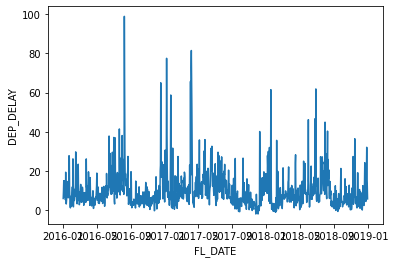

In [5]:
#plot of the time series
sns.lineplot(data = df_delay , x = df_delay.index, y = df_delay['DEP_DELAY'])

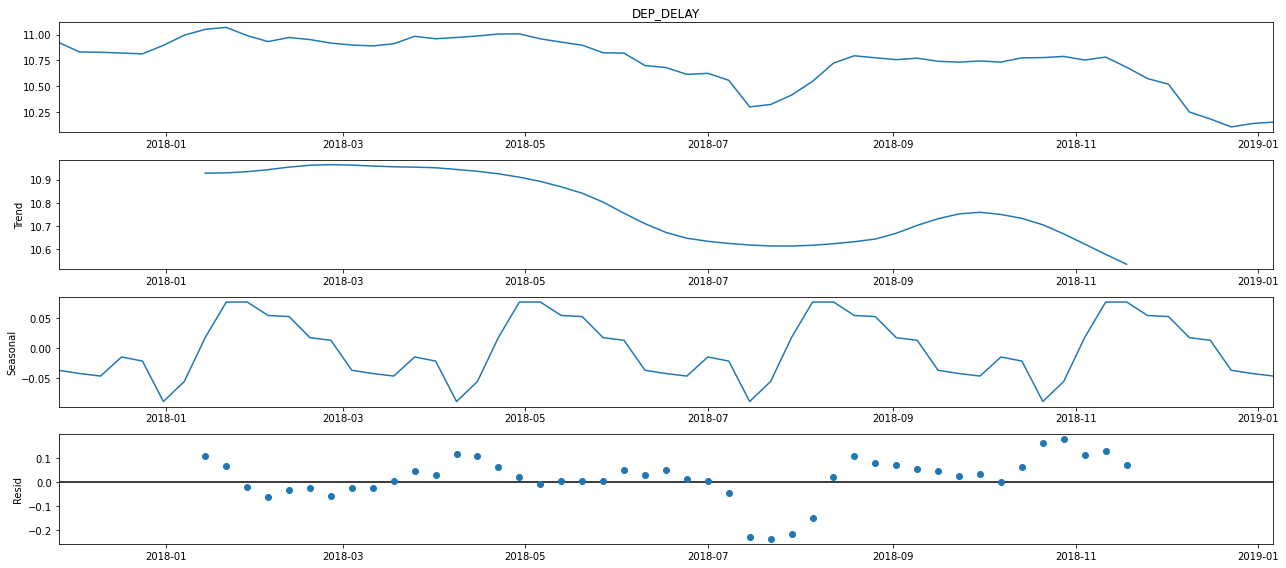

In [6]:
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
sig = df_delay['DEP_DELAY'].resample('W').mean()
decomposition = sm.tsa.seasonal_decompose(x = sig.rolling(100).mean().dropna(), period=14, model='additive')
fig = decomposition.plot()
plt.show()

##2.2) Autocorrelation

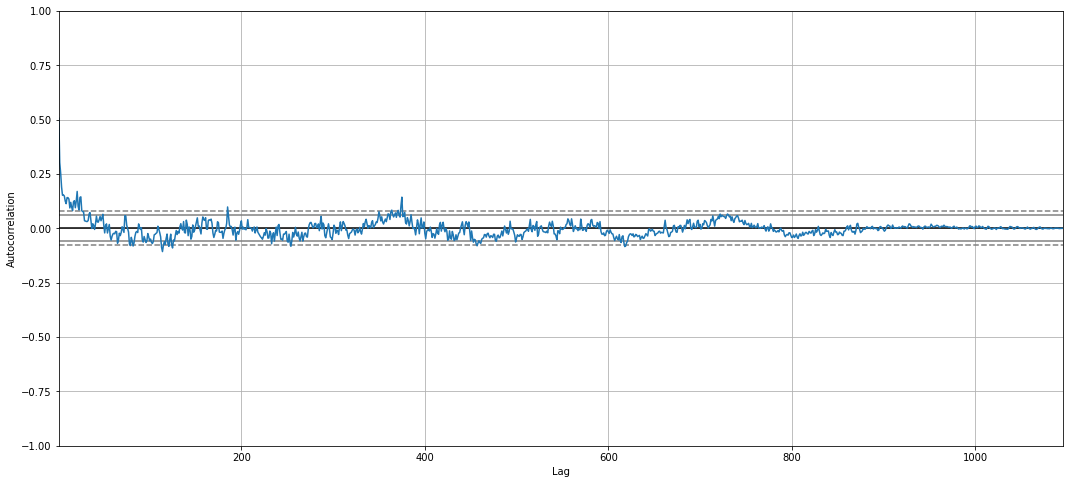

In [7]:
from pandas.plotting import autocorrelation_plot
 
autocorrelation_plot(df_delay[:100000]) #this plot is plotting the correlations values by lag
plt.show()

##2.3) Stationary test

In [8]:
from statsmodels.tsa.stattools import kpss

kpss(df_delay, regression='c', nlags = 'auto')
#We reject the null hypothesis (P=0.1 < alpha=0.05), so it's stationary with 95% confidence

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.28374007132757506,
 0.1,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [9]:
kpss(df_delay, regression='ct', nlags = 'auto')

#We reject the null hypothesis (P=0.06 < alpha=0.05), so it's stationary with 95% confidence

(0.14074002491913623,
 0.05974069459419215,
 15,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

##2.4) ARIMA Model

In [10]:
print(df_delay.shape) #25% of 1096 is 274
print(df_delay.tail(274).shape)

(1096, 1)
(274, 1)


In [26]:
### ARIMA 
# Create the train set
train_set = df_delay.head(int(df_delay.shape[0]-273))
print(train_set.shape)
print('The minimum date we have is', train_set.index.min(), 'and the maximum date is ',  train_set.index.max())

# Create the test set
test_set = df_delay.tail(273)
print(test_set.shape)
print('The minimum date we have is', test_set.index.min(), 'and the maximum date is ',  test_set.index.max())

(823, 1)
The minimum date we have is 2016-01-01 00:00:00 and the maximum date is  2018-04-02 00:00:00
(273, 1)
The minimum date we have is 2018-04-03 00:00:00 and the maximum date is  2018-12-31 00:00:00


In [12]:
#tune the parameters p, d, q using auto_arima
auto_arima(df_delay)
#best tuning with: p = 2, d = 0, q = 1

ARIMA(order=(2, 0, 1), scoring_args={}, suppress_warnings=True)

In [13]:
#fit model to the optimized parameters
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_set.values, order=(2,0,1))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

#forecast
arima_model_fit.forecast()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  823
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -2937.428
Date:                Thu, 05 Jan 2023   AIC                           5884.856
Time:                        16:37:10   BIC                           5908.421
Sample:                             0   HQIC                          5893.897
                                - 823                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5481      1.858      5.678      0.000       6.907      14.189
ar.L1          1.3860      0.049     28.310      0.000       1.290       1.482
ar.L2         -0.4064      0.038    -10.599      0.0

array([10.78464111])

In [14]:
#check if it makes sense, the value makes sense with the whole dataframe and is actually close to the mean
df_delay.mean()

DEP_DELAY    10.339835
dtype: float64

In [15]:
#create a plot with the prediction vs real values
#create a column with the prediction


In [16]:
#lineplot the residuals

# # line plot of residuals
# residuals = DataFrame(model_fit.resid)
# residuals.plot()
# pyplot.show()
# # density plot of residuals
# residuals.plot(kind='kde')
# pyplot.show()
# # summary stats of residuals
# print(residuals.describe())

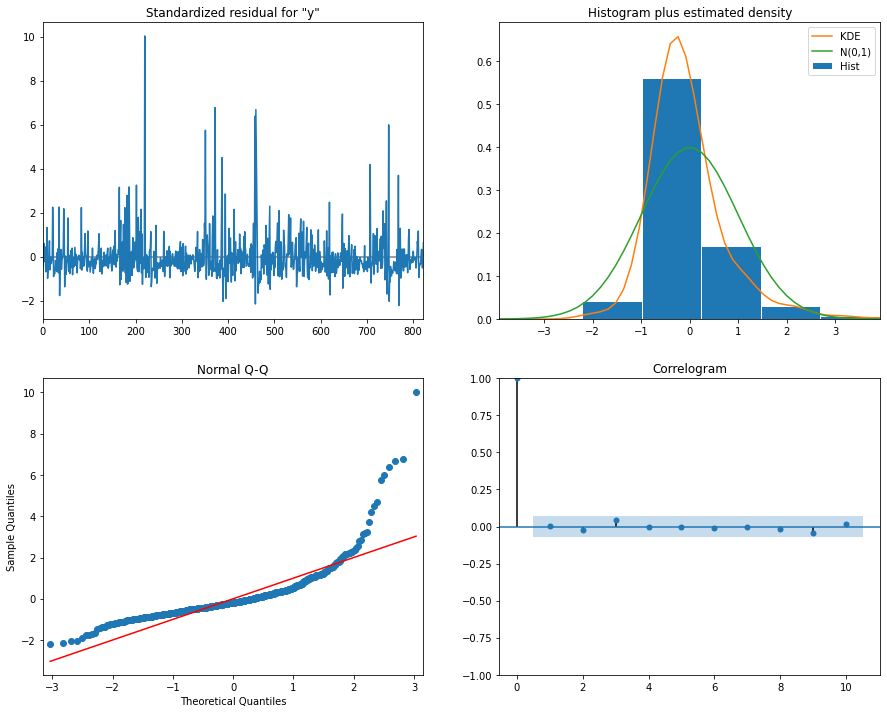

In [17]:
arima_model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [18]:
allx = list(range(1, 274))
allx.reverse()

def forecastx(x):
    test_set = df_delay.tail(x)
    train_set = df_delay.head(int(df_delay.shape[0]-test_set.shape[0]))
    arima_model = ARIMA(train_set['DEP_DELAY'], order=(2,0,1), freq = 'D')
    arima_model_fit = arima_model.fit()
    arima_model_fit.forecast()
    forecast =  arima_model_fit.forecast()
    return forecast

dep_delay_forecast = list(map(forecastx, allx))
dep_delay_forecast

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was 

[2018-04-03    10.784641
 Freq: D, dtype: float64, 2018-04-04    10.706062
 Freq: D, dtype: float64, 2018-04-05    10.540641
 Freq: D, dtype: float64, 2018-04-06    7.554097
 Freq: D, dtype: float64, 2018-04-07    10.242052
 Freq: D, dtype: float64, 2018-04-08    7.91849
 Freq: D, dtype: float64, 2018-04-09    7.452532
 Freq: D, dtype: float64, 2018-04-10    8.686263
 Freq: D, dtype: float64, 2018-04-11    6.842376
 Freq: D, dtype: float64, 2018-04-12    5.41741
 Freq: D, dtype: float64, 2018-04-13    6.317359
 Freq: D, dtype: float64, 2018-04-14    6.989865
 Freq: D, dtype: float64, 2018-04-15    7.098586
 Freq: D, dtype: float64, 2018-04-16    15.902651
 Freq: D, dtype: float64, 2018-04-17    18.338265
 Freq: D, dtype: float64, 2018-04-18    9.015274
 Freq: D, dtype: float64, 2018-04-19    6.467661
 Freq: D, dtype: float64, 2018-04-20    8.291106
 Freq: D, dtype: float64, 2018-04-21    7.044503
 Freq: D, dtype: float64, 2018-04-22    6.753228
 Freq: D, dtype: float64, 2018-04-23    8

In [19]:
#testing to create a series, each value is a list
forecast = pd.Series(dep_delay_forecast)
type(forecast[1]) # it's a series

pandas.core.series.Series

In [32]:
#so, if we pd.concat, we get a series with each value as a value
forecast = pd.concat(dep_delay_forecast)
type(forecast)

pandas.core.series.Series

In [21]:
#now, we can create a dataframe and compare the test_set and the forescasted values
test_forecast = pd.concat([test_set, forecast], axis = 1)
test_forecast = test_forecast.rename(columns={'DEP_DELAY' : 'Test_set', 0: 'Forecast'})
test_forecast

,Test_set,Forecast
2018-04-03,12.306523,10.784641
2018-04-04,11.730656,10.706062
2018-04-05,5.262163,10.540641
2018-04-06,11.131015,7.554097
2018-04-07,6.083773,10.242052
...,...,...
2018-12-27,20.029929,7.669784
2018-12-28,32.150881,13.731376
2018-12-29,15.529323,19.611367
2018-12-30,12.451690,12.778915


In [24]:
#we can plot it
fig = px.line(test_forecast, x = test_forecast.index, y = ['Test_set', 'Forecast']) #, color_discrete_sequence=["#ff97ff"])
fig.show()

In [27]:
# To evaluate the forecast we use the mean squared error
from sklearn.metrics import mean_squared_error

mean_squared_error(test_forecast['Test_set'], test_forecast['Forecast']) #59.93

#https://www.bmc.com/blogs/mean-squared-error-r2-and-variance-in-regression-analysis/
#There is no correct value for MSE. Simply put, the lower the value the better and 0 means the model is perfect. 
#Since there is no correct answer, the MSE’s basic value is in selecting one prediction model over another.

59.93489540256182

In [ ]:
# #delay_forecast = df_delay.join(forecast.rename('new'), how="outer")
# delay_forecast = test_forecast.rename(columns={0: 'Forecast'})
# delay_forecast